(0.0, 0.15)

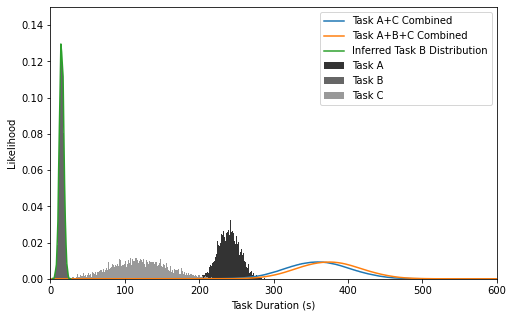

In [151]:
################################### Import the relevant packages for testing
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

################################### We'll ultimately plot the results of our analysis
fig = plt.figure(figsize=(8,5))

################################### We are going to synthesize some task duration distributions
################################### and establish probability distribution functions for each of them
################################### with 1s resolution
dt = 1
t_edges = np.arange(-0.5,600.5,dt)
t_mids = (t_edges[1:]+t_edges[:-1])/2

################################## Draw 5000 samples from a random normal distribution with known mean and standard deviations.
################################## These represent the three component tasks
task_a_duration = np.random.normal(240,15,size=[5000,1])
task_b_duration = np.random.normal(15,3,size=[5000,1])
task_c_duration = np.random.normal(120,40,size=[5000,1])

################################## Here, we plot the distributions and extract the probability distribution function for each task
dist_a = plt.hist(task_a_duration,bins=t_edges,density=True,label='Task A',color=[0.2,0.2,0.2]);
dist_b = plt.hist(task_b_duration,bins=t_edges,density=True,label='Task B',color=[0.4,0.4,0.4]);
dist_c = plt.hist(task_c_duration,bins=t_edges,density=True,label='Task C',color=[0.6,0.6,0.6]);

################################## Here we produce the combined distributions for tasks ac and tasks abc by convolution.
################################## Convolution can be performed numerically (which is essentially a loop) or approximated
################################## by taking the ifft of the dot product of the fft of each curve. This is faster, but
################################## can introduce numerical artifacts. The reason the convolution operation combines
################################## probability distribution functions is because it ultimately calculates the likelihood
################################## of every combination of task a and task b, and gets the sum of all likelihoods for each outcome.
################################## IE -- you can have a total task time of 30 seconds with 10+20 and 11+19, the convolution
################################## calculates the odds of each of those combinations and adds them to give likelihoods for new
################################## total times.
ac_distribution = np.convolve(dist_a[0],dist_c[0],mode='full')
ac_distribution_ft = scipy.signal.fftconvolve(dist_a[0],dist_c[0])

abc_distribution = np.convolve(ac_distribution,dist_b[0],mode='full')
abc_distribution_ft = scipy.signal.fftconvolve(ac_distribution,dist_b[0])

################################## Importantly, "mode='full'" in the convolution function calculates the result for
################################## every overlapping shift of the second series. What that means is that the length of
################################## your output array will now be len(a) + len(b) - 1. This is because the first overlapping
################################## shift has only one sample from each series. For shifts 1 to len(b), the overlap between
################################## the two series grows, from shifts len(b) to len(a), all of series b is overlapping
################################## part of series a, and then from shifts len(a) to len(a)+len(b)-1, the overlap is shrinking.
################################## You need to construct a new time axis for this new shaped array to compare with your
################################## earlier distributions.
t_conv1 = np.concatenate([t_mids,t_mids[1:]+np.max(t_mids)])
t_conv2 = np.concatenate([t_conv1,t_mids[1:]+np.max(t_mids)])

################################## Here we plot the combined distributions
plt.plot(t_conv1,ac_distribution,label='Task A+C Combined')
plt.plot(t_conv2,abc_distribution_ft,label='Task A+B+C Combined')

################################## Deconvolution does this operation in reverse. If we know the combined distribution for
################################## a+b+c and for a+c, deconvolving a+b+c using a+c should give you the distribution of b.

################################## Numerically, scipy's deconvolve function can't handle 0 values in the input array.
################################## Here I reduce each of them to just the non-zero central portion. You have to 
################################## reconstruct the appropriate new time axis for the output of the deconvolution, which 
################################## can be derived from the time axes of the original curves. 
ki_1 = np.where(ac_distribution > 0)
ac_distribution_for_deconv = ac_distribution[ki_1]

ki_2 = np.where(abc_distribution > 0)
abc_distribution_for_deconv = abc_distribution[ki_2]

approx_task_b = scipy.signal.deconvolve(abc_distribution_for_deconv,ac_distribution_for_deconv)[0]

################################## We reconstruct the correct time axis. We have an initial shift associated with 
################################## removed samples at the front of the abc distribution (t_conv2[ki2[0][0]]) that
################################## would be partially offset by the samples removed from the ab distribution 
################################## (t_conv1[ki_1[0][0]])
t0 = t_conv2[ki_2[0][0]]-t_conv1[ki_1[0][0]]
t_range = np.arange(0,len(approx_task_b))*dt
t_deconv = t0+t_range

################################## We can plot the final inferred distribution for task B!
plt.plot(t_deconv,approx_task_b,label='Inferred Task B Distribution')
plt.ylim([0,0.13])

plt.legend()
plt.xlabel('Task Duration (s)')
plt.ylabel('Likelihood')
plt.xlim([0,600])
plt.ylim([0,0.15])